SLaM (Source, Light and Mass): Light Parametric + Mass Total + Subhalo NFW + Source Parametric
==============================================================================================

SLaM pipelines break the analysis of 'galaxy-scale' strong lenses down into multiple pipelines which focus on modeling
a specific aspect of the strong lens, first the Source, then the (lens) Light and finally the Mass. Each of these
pipelines has it own inputs which which customize the model and analysis in that pipeline.

The models fitted in earlier pipelines determine the model used in later pipelines. For example, if the SOURCE PIPELINE
uses a parametric `EllSersic` profile for the bulge, this will be used in the subsequent MASS TOTAL PIPELINE.

Using a SOURCE PARAMETRIC PIPELINE, LIGHT PARAMETRIC PIPELINE, MASS TOTAL PIPELINE and SUBHALO PIPELINE this SLaM script
fits `Interferometer` of a strong lens system, where in the final model:

 - The lens galaxy's light is a bulge+disk `EllSersic` and `EllExponential`.
 - The lens galaxy's total mass distribution is an `EllIsothermal`.
 - A dark matter subhalo near The lens galaxy mass is included as a`SphNFWMCRLudLow`.
 - The source galaxy is an `Inversion`.

This uses the SLaM pipelines:

 `source_parametric/with_lens_light`
 `source__inversion/with_lens_light`
 `light_parametric/with_lens_light`
 `mass_total/with_lens_light`
 `subhalo/detection_single_plane`

Check them out for a full description of the analysis!

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import os
import sys
from os import path
from utils import fitutil as af
import utils as al
import utils.plot as aplt

sys.path.insert(0, os.getcwd())
from utils import slamutil as slam

/workspace
Working Directory has been set to `/workspace`


2021-10-14 18:09:52,280 - confutil.conf - WARNING - Pushing new config with path /workspace/utils/utils/fitutil/config
2021-10-14 18:09:52,328 - confutil.conf - WARNING - No configuration found at path /workspace/config


2021-10-14 18:09:52,379 - confutil.conf - WARNING - Pushing new config with path /workspace/utils/utils/galaxyutil/config
2021-10-14 18:09:52,442 - confutil.conf - WARNING - No configuration found at path /workspace/config
2021-10-14 18:09:53,611 - confutil.conf - WARNING - Pushing new config with path /workspace/utils/config
2021-10-14 18:09:53,670 - confutil.conf - WARNING - No configuration found at path /workspace/config


__Dataset + Masking__ 

Load the `Interferometer` data, define the visibility and real-space masks and plot them.

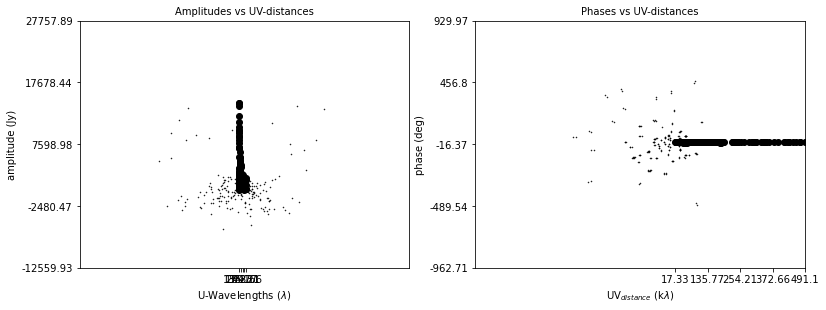

/usr/local/lib/python3.9/site-packages/pynufft/linalg/nufft_cpu.py:381: ComplexWarning: Casting complex values to real discards the imaginary part
  xx.ravel()[self.NdCPUorder * self.batch + bat] = k.ravel()[


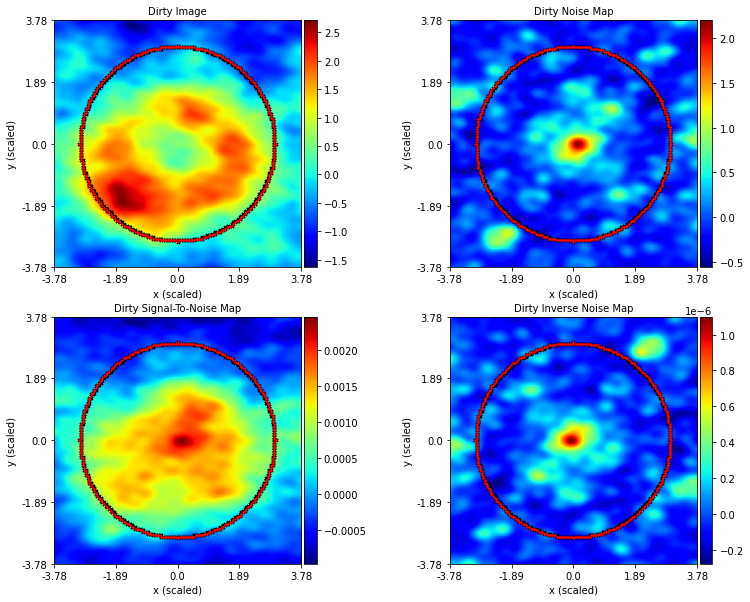

In [2]:
real_space_mask = al.Mask2D.circular(
    shape_native=(151, 151), pixel_scales=0.05, radius=3.0
)

dataset_name = "mass_sie__subhalo_nfw__source_sersic_x2"
dataset_path = path.join("dataset", "interferometer", dataset_name)

interferometer = al.Interferometer.from_fits(
    visibilities_path=path.join(dataset_path, "visibilities.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    uv_wavelengths_path=path.join(dataset_path, "uv_wavelengths.fits"),
    real_space_mask=real_space_mask,
)
interferometer = interferometer.apply_settings(
    settings=al.SettingsInterferometer(transformer_class=al.TransformerNUFFT)
)

interferometer_plotter = aplt.InterferometerPlotter(interferometer=interferometer)
interferometer_plotter.subplot_interferometer()
interferometer_plotter.subplot_dirty_images()

__Settings__

The settings which controls the output paths, parallelization, database use, etc.

In [3]:
settings_autofit = slam.SettingsAutoFit(
    path_prefix=path.join("interferometer", "slam"),
    unique_tag=dataset_name,
    info=None,
    number_of_cores=None,
    session=None,
)

__Redshifts__

The redshifts of the lens and source galaxies, which are used to perform unit converions of the model and data (e.g. 
from arc-seconds to kiloparsecs, masses to solar masses, etc.).

In [4]:
redshift_lens = 0.5
redshift_source = 1.0

__HYPER SETUP__

The `SetupHyper` determines which hyper-mode features are used during the model-fit.

In [5]:
setup_hyper = al.SetupHyper(
    hyper_galaxies_lens=False,
    hyper_galaxies_source=False,
    hyper_image_sky=None,
    hyper_background_noise=None,
)

__SOURCE PARAMETRIC PIPELINE (with lens light)__

The SOURCE PARAMETRIC PIPELINE (with lens light) uses three searches to initialize a robust model for the 
source galaxy's light, which in this example:
 
 - Uses a parametric `EllSersic` bulge and `EllExponential` disk with centres aligned for the lens
 galaxy's light.
 
 - Uses an `EllIsothermal` model for the lens's total mass distribution with an `ExternalShear`.

 __Settings__:

 - Mass Centre: Fix the mass profile centre to (0.0, 0.0) (this assumption will be relaxed in the MASS TOTAL PIPELINE).

In [ ]:
analysis = al.AnalysisInterferometer(dataset=interferometer)

bulge = af.Model(al.lp.EllSersic)
disk = af.Model(al.lp.EllExponential)
bulge.centre = disk.centre

source_parametric_results = slam.source_parametric.with_lens_light(
    settings_autofit=settings_autofit,
    analysis=analysis,
    setup_hyper=setup_hyper,
    lens_bulge=bulge,
    lens_disk=disk,
    mass=af.Model(al.mp.EllIsothermal),
    shear=af.Model(al.mp.ExternalShear),
    source_bulge=af.Model(al.lp.EllSersic),
    mass_centre=(0.0, 0.0),
    redshift_lens=redshift_lens,
    redshift_source=redshift_source,
)

__SOURCE INVERSION PIPELINE (with lens light)__

The SOURCE INVERSION PIPELINE (with lens light) uses four searches to initialize a robust model for the `Inversion` 
that reconstructs the source galaxy's light. It begins by fitting a `VoronoiMagnification` pixelization with `Constant` 
regularization, to set up the model and hyper images, and then:

 - Uses a `VoronoiBrightnessImage` pixelization.
 - Uses an `AdaptiveBrightness` regularization.
 - Carries the lens redshift, source redshift and `ExternalShear` of the SOURCE PARAMETRIC PIPELINE through to the
 SOURCE INVERSION PIPELINE.

__Settings__:

 - Positions: We update the positions and positions threshold using the previous model-fitting result (as described 
 in `chaining/parametric_to_inversion.ipynb`) to remove unphysical solutions from the `Inversion` model-fitting.

In [ ]:
settings_lens = al.SettingsLens(positions_threshold=0.2)

analysis = al.AnalysisInterferometer(
    dataset=interferometer,
    positions=source_parametric_results.last.image_plane_multiple_image_positions,
    settings_lens=settings_lens,
)

source_inversion_results = slam.source_inversion.with_lens_light(
    settings_autofit=settings_autofit,
    analysis=analysis,
    setup_hyper=setup_hyper,
    source_parametric_results=source_parametric_results,
    pixelization=al.pix.VoronoiBrightnessImage,
    regularization=al.reg.AdaptiveBrightness,
)

__LIGHT PARAMETRIC PIPELINE__

The LIGHT PARAMETRIC PIPELINE uses one search to fit a complex lens light model to a high level of accuracy, using the
lens mass model and source light model fixed to the maximum log likelihood result of the SOURCE INVERSION PIPELINE.
In this example it:

 - Uses a parametric `EllSersic` bulge and `EllSersic` disk with centres aligned for the lens galaxy's 
 light [Do not use the results of the SOURCE PARAMETRIC PIPELINE to initialize priors].

 - Uses an `EllIsothermal` model for the lens's total mass distribution [fixed from SOURCE INVERSION PIPELINE].

 - Uses an `Inversion` for the source's light [priors fixed from SOURCE INVERSION PIPELINE].

 - Carries the lens redshift, source redshift and `ExternalShear` of the SOURCE PIPELINE through to the MASS 
 PIPELINE [fixed values].

In [ ]:
settings_lens = al.SettingsLens(
    positions_threshold=source_inversion_results.last.positions_threshold_from(
        factor=3.0, minimum_threshold=0.2
    )
)

analysis = al.AnalysisInterferometer(
    dataset=interferometer,
    hyper_dataset_result=source_inversion_results.last,
    positions=source_inversion_results.last.image_plane_multiple_image_positions,
    settings_lens=settings_lens,
)

bulge = af.Model(al.lp.EllSersic)
disk = af.Model(al.lp.EllExponential)
bulge.centre = disk.centre

light_results = slam.light_parametric.with_lens_light(
    settings_autofit=settings_autofit,
    analysis=analysis,
    setup_hyper=setup_hyper,
    source_results=source_inversion_results,
    lens_bulge=bulge,
    lens_disk=disk,
)

__MASS TOTAL PIPELINE (with lens light)__

The MASS TOTAL PIPELINE (with lens light) uses one search to fits a complex lens mass model to a high level of accuracy, 
using the lens mass model and source model of the SOURCE PIPELINE to initialize the model priors and the lens light
model of the LIGHT PARAMETRIC PIPELINE. In this example it:

 - Uses a parametric `EllSersic` bulge and `EllSersic` disk with centres aligned for the lens galaxy's 
 light [fixed from LIGHT PARAMETRIC PIPELINE].

 - Uses an `EllPowerLaw` model for the lens's total mass distribution [priors initialized from SOURCE 
 PARAMETRIC PIPELINE + centre unfixed from (0.0, 0.0)].
 
 - Uses the `EllSersic` model representing a bulge for the source's light [priors initialized from SOURCE 
 PARAMETRIC PIPELINE].
 
 - Carries the lens redshift, source redshift and `ExternalShear` of the SOURCE PIPELINE through to the MASS TOTAL PIPELINE.

In [ ]:
settings_lens = al.SettingsLens(
    positions_threshold=source_inversion_results.last.positions_threshold_from(
        factor=3.0, minimum_threshold=0.2
    )
)

analysis = al.AnalysisInterferometer(
    dataset=interferometer,
    hyper_dataset_result=source_inversion_results.last,
    positions=source_inversion_results.last.image_plane_multiple_image_positions,
    settings_lens=settings_lens,
)

mass_results = slam.mass_total.with_lens_light(
    settings_autofit=settings_autofit,
    analysis=analysis,
    setup_hyper=setup_hyper,
    source_results=source_inversion_results,
    light_results=light_results,
    mass=af.Model(al.mp.EllPowerLaw),
)

__SUBHALO PIPELINE (single plane detection)__

The SUBHALO PIPELINE (single plane detection) consists of the following searches:
 
 1) Refit the lens and source model, to refine the model evidence for comparing to the models fitted which include a 
 subhalo. This uses the same model as fitted in the MASS TOTAL PIPELINE. 
 2) Performs a grid-search of non-linear searches to attempt to detect a dark matter subhalo. 
 3) If there is a successful detection a final search is performed to refine its parameters.
 
For this runner the SUBHALO PIPELINE customizes:

 - The [number_of_steps x number_of_steps] size of the grid-search, as well as the dimensions it spans in arc-seconds.
 - The `number_of_cores` used for the gridsearch, where `number_of_cores > 1` performs the model-fits in paralle using
 the Python multiprocessing module.

In [ ]:
settings_lens = al.SettingsLens(
    positions_threshold=mass_results.last.positions_threshold_from(
        factor=3.0, minimum_threshold=0.2
    )
)

preloads = al.Preloads.setup(
    result=source_inversion_results.last.hyper, pixelization=True
)

analysis = al.AnalysisInterferometer(
    dataset=interferometer,
    hyper_dataset_result=source_inversion_results.last,
    positions=mass_results.last.image_plane_multiple_image_positions,
    settings_lens=settings_lens,
    preloads=preloads,
)

subhalo_results = slam.subhalo.detection_single_plane(
    settings_autofit=settings_autofit,
    analysis=analysis,
    setup_hyper=setup_hyper,
    mass_results=mass_results,
    subhalo_mass=af.Model(al.mp.SphNFWMCRLudlow),
    grid_dimension_arcsec=3.0,
    number_of_steps=5,
)

Finish.